In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
data_df = pd.read_csv('../../../_data/Kr2010.csv', index_col=0)
data_df['sbj'] -= 1

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [9]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(tr_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

obs_test = np.asarray(ts_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(ts_df[['item_value_1', 'item_value_2', 'gaze_1', 'gaze_2']])

print(X_train.shape, X_test.shape)

(2096, 4) (1426, 4)


In [10]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 1e-14)), axis=-1)

In [11]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [12]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 129       
                                                                 
Total params: 422 (1.65 KB)
Trainable params: 422 (1.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [13]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [14]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 570ms/step - loss: 12753.3115
Epoch 2/5000
1/1 [==============================] - 0s 2ms/step - loss: 12697.3516
Epoch 3/5000
1/1 [==============================] - 0s 2ms/step - loss: 12657.4785
Epoch 4/5000
1/1 [==============================] - 0s 2ms/step - loss: 12624.2734
Epoch 5/5000
1/1 [==============================] - 0s 2ms/step - loss: 12594.8711
Epoch 6/5000
1/1 [==============================] - 0s 2ms/step - loss: 12567.9766
Epoch 7/5000
1/1 [==============================] - 0s 2ms/step - loss: 12542.8828
Epoch 8/5000
1/1 [==============================] - 0s 2ms/step - loss: 12519.1582
Epoch 9/5000
1/1 [==============================] - 0s 2ms/step - loss: 12496.5137
Epoch 10/5000
1/1 [==============================] - 0s 4ms/step - loss: 12474.7539
Epoch 11/5000
1/1 [==============================] - 0s 2ms/step - loss: 12453.7266
Epoch 12/5000
1/1 [==============================] - 0s 2ms/step - loss: 12433.3223

1/1 [==============================] - 0s 2ms/step - loss: 11138.9004
Epoch 99/5000
1/1 [==============================] - 0s 2ms/step - loss: 11127.3691
Epoch 100/5000
1/1 [==============================] - 0s 2ms/step - loss: 11115.9131
Epoch 101/5000
1/1 [==============================] - 0s 3ms/step - loss: 11104.5322
Epoch 102/5000
1/1 [==============================] - 0s 2ms/step - loss: 11093.2246
Epoch 103/5000
1/1 [==============================] - 0s 2ms/step - loss: 11081.9902
Epoch 104/5000
1/1 [==============================] - 0s 2ms/step - loss: 11070.8281
Epoch 105/5000
1/1 [==============================] - 0s 2ms/step - loss: 11059.7373
Epoch 106/5000
1/1 [==============================] - 0s 2ms/step - loss: 11048.7158
Epoch 107/5000
1/1 [==============================] - 0s 2ms/step - loss: 11037.7666
Epoch 108/5000
1/1 [==============================] - 0s 3ms/step - loss: 11026.8867
Epoch 109/5000
1/1 [==============================] - 0s 2ms/step - loss: 11016.0

1/1 [==============================] - 0s 2ms/step - loss: 10289.7754
Epoch 195/5000
1/1 [==============================] - 0s 3ms/step - loss: 10282.9316
Epoch 196/5000
1/1 [==============================] - 0s 2ms/step - loss: 10276.1182
Epoch 197/5000
1/1 [==============================] - 0s 2ms/step - loss: 10269.3340
Epoch 198/5000
1/1 [==============================] - 0s 2ms/step - loss: 10262.5791
Epoch 199/5000
1/1 [==============================] - 0s 2ms/step - loss: 10255.8496
Epoch 200/5000
1/1 [==============================] - 0s 2ms/step - loss: 10249.1514
Epoch 201/5000
1/1 [==============================] - 0s 2ms/step - loss: 10242.4805
Epoch 202/5000
1/1 [==============================] - 0s 2ms/step - loss: 10235.8379
Epoch 203/5000
1/1 [==============================] - 0s 2ms/step - loss: 10229.2207
Epoch 204/5000
1/1 [==============================] - 0s 2ms/step - loss: 10222.6328
Epoch 205/5000
1/1 [==============================] - 0s 2ms/step - loss: 10216.

1/1 [==============================] - 0s 2ms/step - loss: 9732.8877
Epoch 292/5000
1/1 [==============================] - 0s 3ms/step - loss: 9728.0244
Epoch 293/5000
1/1 [==============================] - 0s 2ms/step - loss: 9723.1738
Epoch 294/5000
1/1 [==============================] - 0s 2ms/step - loss: 9718.3379
Epoch 295/5000
1/1 [==============================] - 0s 2ms/step - loss: 9713.5137
Epoch 296/5000
1/1 [==============================] - 0s 2ms/step - loss: 9708.7051
Epoch 297/5000
1/1 [==============================] - 0s 2ms/step - loss: 9703.9092
Epoch 298/5000
1/1 [==============================] - 0s 2ms/step - loss: 9699.1270
Epoch 299/5000
1/1 [==============================] - 0s 3ms/step - loss: 9694.3574
Epoch 300/5000
1/1 [==============================] - 0s 2ms/step - loss: 9689.5996
Epoch 301/5000
1/1 [==============================] - 0s 2ms/step - loss: 9684.8555
Epoch 302/5000
1/1 [==============================] - 0s 2ms/step - loss: 9680.1250
Epoch 3

1/1 [==============================] - 0s 2ms/step - loss: 9303.2578
Epoch 389/5000
1/1 [==============================] - 0s 2ms/step - loss: 9298.5195
Epoch 390/5000
1/1 [==============================] - 0s 2ms/step - loss: 9293.6787
Epoch 391/5000
1/1 [==============================] - 0s 3ms/step - loss: 9288.7256
Epoch 392/5000
1/1 [==============================] - 0s 2ms/step - loss: 9283.6562
Epoch 393/5000
1/1 [==============================] - 0s 2ms/step - loss: 9278.4629
Epoch 394/5000
1/1 [==============================] - 0s 2ms/step - loss: 9273.1426
Epoch 395/5000
1/1 [==============================] - 0s 2ms/step - loss: 9267.7012
Epoch 396/5000
1/1 [==============================] - 0s 2ms/step - loss: 9262.1406
Epoch 397/5000
1/1 [==============================] - 0s 2ms/step - loss: 9256.4707
Epoch 398/5000
1/1 [==============================] - 0s 7ms/step - loss: 9250.6953
Epoch 399/5000
1/1 [==============================] - 0s 2ms/step - loss: 9244.8262
Epoch 4

1/1 [==============================] - 0s 2ms/step - loss: 8778.9131
Epoch 486/5000
1/1 [==============================] - 0s 2ms/step - loss: 8773.7217
Epoch 487/5000
1/1 [==============================] - 0s 2ms/step - loss: 8768.5352
Epoch 488/5000
1/1 [==============================] - 0s 2ms/step - loss: 8763.3496
Epoch 489/5000
1/1 [==============================] - 0s 2ms/step - loss: 8758.1699
Epoch 490/5000
1/1 [==============================] - 0s 2ms/step - loss: 8752.9951
Epoch 491/5000
1/1 [==============================] - 0s 2ms/step - loss: 8747.8242
Epoch 492/5000
1/1 [==============================] - 0s 2ms/step - loss: 8742.6582
Epoch 493/5000
1/1 [==============================] - 0s 2ms/step - loss: 8737.4990
Epoch 494/5000
1/1 [==============================] - 0s 2ms/step - loss: 8732.3457
Epoch 495/5000
1/1 [==============================] - 0s 2ms/step - loss: 8727.1953
Epoch 496/5000
1/1 [==============================] - 0s 2ms/step - loss: 8722.0527
Epoch 4

1/1 [==============================] - 0s 2ms/step - loss: 8281.4180
Epoch 583/5000
1/1 [==============================] - 0s 2ms/step - loss: 8273.2656
Epoch 584/5000
1/1 [==============================] - 0s 2ms/step - loss: 8264.8164
Epoch 585/5000
1/1 [==============================] - 0s 2ms/step - loss: 8256.1152
Epoch 586/5000
1/1 [==============================] - 0s 3ms/step - loss: 8247.1992
Epoch 587/5000
1/1 [==============================] - 0s 2ms/step - loss: 8238.1162
Epoch 588/5000
1/1 [==============================] - 0s 2ms/step - loss: 8228.9102
Epoch 589/5000
1/1 [==============================] - 0s 3ms/step - loss: 8219.6230
Epoch 590/5000
1/1 [==============================] - 0s 2ms/step - loss: 8210.2881
Epoch 591/5000
1/1 [==============================] - 0s 3ms/step - loss: 8200.9385
Epoch 592/5000
1/1 [==============================] - 0s 2ms/step - loss: 8191.6001
Epoch 593/5000
1/1 [==============================] - 0s 2ms/step - loss: 8182.2939
Epoch 5

1/1 [==============================] - 0s 2ms/step - loss: 7584.1289
Epoch 680/5000
1/1 [==============================] - 0s 2ms/step - loss: 7579.0957
Epoch 681/5000
1/1 [==============================] - 0s 2ms/step - loss: 7574.0479
Epoch 682/5000
1/1 [==============================] - 0s 2ms/step - loss: 7569.0381
Epoch 683/5000
1/1 [==============================] - 0s 2ms/step - loss: 7564.0127
Epoch 684/5000
1/1 [==============================] - 0s 3ms/step - loss: 7559.0264
Epoch 685/5000
1/1 [==============================] - 0s 2ms/step - loss: 7554.0225
Epoch 686/5000
1/1 [==============================] - 0s 2ms/step - loss: 7549.0557
Epoch 687/5000
1/1 [==============================] - 0s 2ms/step - loss: 7544.0708
Epoch 688/5000
1/1 [==============================] - 0s 2ms/step - loss: 7539.1240
Epoch 689/5000
1/1 [==============================] - 0s 2ms/step - loss: 7534.1582
Epoch 690/5000
1/1 [==============================] - 0s 4ms/step - loss: 7529.2305
Epoch 6

1/1 [==============================] - 0s 2ms/step - loss: 7144.1631
Epoch 777/5000
1/1 [==============================] - 0s 2ms/step - loss: 7140.1250
Epoch 778/5000
1/1 [==============================] - 0s 2ms/step - loss: 7136.1426
Epoch 779/5000
1/1 [==============================] - 0s 2ms/step - loss: 7132.1221
Epoch 780/5000
1/1 [==============================] - 0s 3ms/step - loss: 7128.1582
Epoch 781/5000
1/1 [==============================] - 0s 2ms/step - loss: 7124.1558
Epoch 782/5000
1/1 [==============================] - 0s 2ms/step - loss: 7120.2119
Epoch 783/5000
1/1 [==============================] - 0s 2ms/step - loss: 7116.2266
Epoch 784/5000
1/1 [==============================] - 0s 2ms/step - loss: 7112.3013
Epoch 785/5000
1/1 [==============================] - 0s 4ms/step - loss: 7108.3345
Epoch 786/5000
1/1 [==============================] - 0s 2ms/step - loss: 7104.4277
Epoch 787/5000
1/1 [==============================] - 0s 3ms/step - loss: 7100.4775
Epoch 7

1/1 [==============================] - 0s 4ms/step - loss: 6794.4785
Epoch 874/5000
1/1 [==============================] - 0s 4ms/step - loss: 6791.2925
Epoch 875/5000
1/1 [==============================] - 0s 3ms/step - loss: 6788.0356
Epoch 876/5000
1/1 [==============================] - 0s 3ms/step - loss: 6784.8584
Epoch 877/5000
1/1 [==============================] - 0s 3ms/step - loss: 6781.6211
Epoch 878/5000
1/1 [==============================] - 0s 2ms/step - loss: 6778.4590
Epoch 879/5000
1/1 [==============================] - 0s 3ms/step - loss: 6775.2422
Epoch 880/5000
1/1 [==============================] - 0s 3ms/step - loss: 6772.0830
Epoch 881/5000
1/1 [==============================] - 0s 3ms/step - loss: 6768.8672
Epoch 882/5000
1/1 [==============================] - 0s 3ms/step - loss: 6765.7134
Epoch 883/5000
1/1 [==============================] - 0s 3ms/step - loss: 6762.5146
Epoch 884/5000
1/1 [==============================] - 0s 3ms/step - loss: 6759.3843
Epoch 8

1/1 [==============================] - 0s 3ms/step - loss: 6509.2021
Epoch 971/5000
1/1 [==============================] - 0s 2ms/step - loss: 6506.5381
Epoch 972/5000
1/1 [==============================] - 0s 2ms/step - loss: 6503.9219
Epoch 973/5000
1/1 [==============================] - 0s 4ms/step - loss: 6501.2617
Epoch 974/5000
1/1 [==============================] - 0s 2ms/step - loss: 6498.6558
Epoch 975/5000
1/1 [==============================] - 0s 2ms/step - loss: 6496.0171
Epoch 976/5000
1/1 [==============================] - 0s 3ms/step - loss: 6493.4473
Epoch 977/5000
1/1 [==============================] - 0s 3ms/step - loss: 6490.8369
Epoch 978/5000
1/1 [==============================] - 0s 3ms/step - loss: 6488.3042
Epoch 979/5000
1/1 [==============================] - 0s 3ms/step - loss: 6485.7007
Epoch 980/5000
1/1 [==============================] - 0s 3ms/step - loss: 6483.1787
Epoch 981/5000
1/1 [==============================] - 0s 3ms/step - loss: 6480.5532
Epoch 9

1/1 [==============================] - 0s 2ms/step - loss: 6284.1670
Epoch 1067/5000
1/1 [==============================] - 0s 2ms/step - loss: 6282.0703
Epoch 1068/5000
1/1 [==============================] - 0s 3ms/step - loss: 6280.0093
Epoch 1069/5000
1/1 [==============================] - 0s 3ms/step - loss: 6277.9116
Epoch 1070/5000
1/1 [==============================] - 0s 2ms/step - loss: 6275.8701
Epoch 1071/5000
1/1 [==============================] - 0s 2ms/step - loss: 6273.7896
Epoch 1072/5000
1/1 [==============================] - 0s 2ms/step - loss: 6271.7798
Epoch 1073/5000
1/1 [==============================] - 0s 2ms/step - loss: 6269.7080
Epoch 1074/5000
1/1 [==============================] - 0s 3ms/step - loss: 6267.7129
Epoch 1075/5000
1/1 [==============================] - 0s 2ms/step - loss: 6265.6338
Epoch 1076/5000
1/1 [==============================] - 0s 2ms/step - loss: 6263.6401
Epoch 1077/5000
1/1 [==============================] - 0s 2ms/step - loss: 6261.5

1/1 [==============================] - 0s 3ms/step - loss: 6108.0283
Epoch 1163/5000
1/1 [==============================] - 0s 2ms/step - loss: 6106.4219
Epoch 1164/5000
1/1 [==============================] - 0s 2ms/step - loss: 6104.9092
Epoch 1165/5000
1/1 [==============================] - 0s 3ms/step - loss: 6103.2969
Epoch 1166/5000
1/1 [==============================] - 0s 3ms/step - loss: 6101.7847
Epoch 1167/5000
1/1 [==============================] - 0s 3ms/step - loss: 6100.1313
Epoch 1168/5000
1/1 [==============================] - 0s 3ms/step - loss: 6098.5996
Epoch 1169/5000
1/1 [==============================] - 0s 3ms/step - loss: 6096.9688
Epoch 1170/5000
1/1 [==============================] - 0s 3ms/step - loss: 6095.4536
Epoch 1171/5000
1/1 [==============================] - 0s 4ms/step - loss: 6093.8926
Epoch 1172/5000
1/1 [==============================] - 0s 2ms/step - loss: 6092.3945
Epoch 1173/5000
1/1 [==============================] - 0s 2ms/step - loss: 6090.8

1/1 [==============================] - 0s 2ms/step - loss: 5975.9771
Epoch 1259/5000
1/1 [==============================] - 0s 3ms/step - loss: 5974.8228
Epoch 1260/5000
1/1 [==============================] - 0s 2ms/step - loss: 5973.7773
Epoch 1261/5000
1/1 [==============================] - 0s 2ms/step - loss: 5972.5825
Epoch 1262/5000
1/1 [==============================] - 0s 3ms/step - loss: 5971.5078
Epoch 1263/5000
1/1 [==============================] - 0s 2ms/step - loss: 5970.2139
Epoch 1264/5000
1/1 [==============================] - 0s 3ms/step - loss: 5969.0879
Epoch 1265/5000
1/1 [==============================] - 0s 3ms/step - loss: 5967.8369
Epoch 1266/5000
1/1 [==============================] - 0s 3ms/step - loss: 5966.7490
Epoch 1267/5000
1/1 [==============================] - 0s 2ms/step - loss: 5965.6196
Epoch 1268/5000
1/1 [==============================] - 0s 2ms/step - loss: 5964.5718
Epoch 1269/5000
1/1 [==============================] - 0s 4ms/step - loss: 5963.4

1/1 [==============================] - 0s 2ms/step - loss: 5879.7432
Epoch 1355/5000
1/1 [==============================] - 0s 2ms/step - loss: 5878.8433
Epoch 1356/5000
1/1 [==============================] - 0s 2ms/step - loss: 5878.0166
Epoch 1357/5000
1/1 [==============================] - 0s 3ms/step - loss: 5877.2051
Epoch 1358/5000
1/1 [==============================] - 0s 2ms/step - loss: 5876.5073
Epoch 1359/5000
1/1 [==============================] - 0s 2ms/step - loss: 5875.6455
Epoch 1360/5000
1/1 [==============================] - 0s 2ms/step - loss: 5874.9131
Epoch 1361/5000
1/1 [==============================] - 0s 2ms/step - loss: 5873.9160
Epoch 1362/5000
1/1 [==============================] - 0s 2ms/step - loss: 5873.0957
Epoch 1363/5000
1/1 [==============================] - 0s 2ms/step - loss: 5872.1436
Epoch 1364/5000
1/1 [==============================] - 0s 2ms/step - loss: 5871.3584
Epoch 1365/5000
1/1 [==============================] - 0s 2ms/step - loss: 5870.5

1/1 [==============================] - 0s 3ms/step - loss: 5809.4775
Epoch 1451/5000
1/1 [==============================] - 0s 3ms/step - loss: 5808.7686
Epoch 1452/5000
1/1 [==============================] - 0s 4ms/step - loss: 5808.0312
Epoch 1453/5000
1/1 [==============================] - 0s 3ms/step - loss: 5807.4092
Epoch 1454/5000
1/1 [==============================] - 0s 3ms/step - loss: 5806.8721
Epoch 1455/5000
1/1 [==============================] - 0s 3ms/step - loss: 5806.3042
Epoch 1456/5000
1/1 [==============================] - 0s 3ms/step - loss: 5805.8428
Epoch 1457/5000
1/1 [==============================] - 0s 4ms/step - loss: 5805.1299
Epoch 1458/5000
1/1 [==============================] - 0s 2ms/step - loss: 5804.5557
Epoch 1459/5000
1/1 [==============================] - 0s 2ms/step - loss: 5803.7539
Epoch 1460/5000
1/1 [==============================] - 0s 3ms/step - loss: 5803.1348
Epoch 1461/5000
1/1 [==============================] - 0s 3ms/step - loss: 5802.4

1/1 [==============================] - 0s 2ms/step - loss: 5756.5518
Epoch 1547/5000
1/1 [==============================] - 0s 2ms/step - loss: 5756.0112
Epoch 1548/5000
1/1 [==============================] - 0s 2ms/step - loss: 5755.3169
Epoch 1549/5000
1/1 [==============================] - 0s 2ms/step - loss: 5754.8408
Epoch 1550/5000
1/1 [==============================] - 0s 2ms/step - loss: 5754.3774
Epoch 1551/5000
1/1 [==============================] - 0s 2ms/step - loss: 5753.9692
Epoch 1552/5000
1/1 [==============================] - 0s 3ms/step - loss: 5753.6621
Epoch 1553/5000
1/1 [==============================] - 0s 2ms/step - loss: 5753.2051
Epoch 1554/5000
1/1 [==============================] - 0s 3ms/step - loss: 5752.7783
Epoch 1555/5000
1/1 [==============================] - 0s 2ms/step - loss: 5752.1143
Epoch 1556/5000
1/1 [==============================] - 0s 2ms/step - loss: 5751.6211
Epoch 1557/5000
1/1 [==============================] - 0s 2ms/step - loss: 5751.0

1/1 [==============================] - 0s 2ms/step - loss: 5714.2769
Epoch 1643/5000
1/1 [==============================] - 0s 2ms/step - loss: 5713.9336
Epoch 1644/5000
1/1 [==============================] - 0s 2ms/step - loss: 5713.2451
Epoch 1645/5000
1/1 [==============================] - 0s 2ms/step - loss: 5712.7646
Epoch 1646/5000
1/1 [==============================] - 0s 2ms/step - loss: 5712.3271
Epoch 1647/5000
1/1 [==============================] - 0s 2ms/step - loss: 5712.0356
Epoch 1648/5000
1/1 [==============================] - 0s 2ms/step - loss: 5711.7666
Epoch 1649/5000
1/1 [==============================] - 0s 2ms/step - loss: 5711.4990
Epoch 1650/5000
1/1 [==============================] - 0s 2ms/step - loss: 5711.1826
Epoch 1651/5000
1/1 [==============================] - 0s 2ms/step - loss: 5710.6118
Epoch 1652/5000
1/1 [==============================] - 0s 2ms/step - loss: 5710.1396
Epoch 1653/5000
1/1 [==============================] - 0s 2ms/step - loss: 5709.6

1/1 [==============================] - 0s 2ms/step - loss: 5678.5566
Epoch 1739/5000
1/1 [==============================] - 0s 2ms/step - loss: 5678.2568
Epoch 1740/5000
1/1 [==============================] - 0s 2ms/step - loss: 5677.5127
Epoch 1741/5000
1/1 [==============================] - 0s 2ms/step - loss: 5677.2393
Epoch 1742/5000
1/1 [==============================] - 0s 2ms/step - loss: 5676.7607
Epoch 1743/5000
1/1 [==============================] - 0s 2ms/step - loss: 5676.3428
Epoch 1744/5000
1/1 [==============================] - 0s 2ms/step - loss: 5676.1133
Epoch 1745/5000
1/1 [==============================] - 0s 3ms/step - loss: 5675.8682
Epoch 1746/5000
1/1 [==============================] - 0s 2ms/step - loss: 5675.7217
Epoch 1747/5000
1/1 [==============================] - 0s 2ms/step - loss: 5675.4346
Epoch 1748/5000
1/1 [==============================] - 0s 2ms/step - loss: 5675.1113
Epoch 1749/5000
1/1 [==============================] - 0s 2ms/step - loss: 5674.5

1/1 [==============================] - 0s 3ms/step - loss: 5647.6245
Epoch 1835/5000
1/1 [==============================] - 0s 2ms/step - loss: 5647.5503
Epoch 1836/5000
1/1 [==============================] - 0s 2ms/step - loss: 5646.9985
Epoch 1837/5000
1/1 [==============================] - 0s 2ms/step - loss: 5647.1260
Epoch 1838/5000
1/1 [==============================] - 0s 2ms/step - loss: 5646.2158
Epoch 1839/5000
1/1 [==============================] - 0s 2ms/step - loss: 5645.7803
Epoch 1840/5000
1/1 [==============================] - 0s 2ms/step - loss: 5645.3926
Epoch 1841/5000
1/1 [==============================] - 0s 3ms/step - loss: 5645.3228
Epoch 1842/5000
1/1 [==============================] - 0s 2ms/step - loss: 5645.0991
Epoch 1843/5000
1/1 [==============================] - 0s 2ms/step - loss: 5645.1265
Epoch 1844/5000
1/1 [==============================] - 0s 2ms/step - loss: 5644.7588
Epoch 1845/5000
1/1 [==============================] - 0s 2ms/step - loss: 5644.4

1/1 [==============================] - 0s 3ms/step - loss: 5620.9209
Epoch 1931/5000
1/1 [==============================] - 0s 3ms/step - loss: 5620.3193
Epoch 1932/5000
1/1 [==============================] - 0s 4ms/step - loss: 5620.0137
Epoch 1933/5000
1/1 [==============================] - 0s 2ms/step - loss: 5620.1450
Epoch 1934/5000
1/1 [==============================] - 0s 2ms/step - loss: 5620.5576
Epoch 1935/5000
1/1 [==============================] - 0s 2ms/step - loss: 5620.4585
Epoch 1936/5000
1/1 [==============================] - 0s 2ms/step - loss: 5619.7480
Epoch 1937/5000
1/1 [==============================] - 0s 4ms/step - loss: 5619.3838
Epoch 1938/5000
1/1 [==============================] - 0s 3ms/step - loss: 5619.3999
Epoch 1939/5000
1/1 [==============================] - 0s 4ms/step - loss: 5618.8818
Epoch 1940/5000
1/1 [==============================] - 0s 2ms/step - loss: 5618.6187
Epoch 1941/5000
1/1 [==============================] - 0s 4ms/step - loss: 5618.4

1/1 [==============================] - 0s 3ms/step - loss: 5597.3633
Epoch 2027/5000
1/1 [==============================] - 0s 3ms/step - loss: 5598.2534
Epoch 2028/5000
1/1 [==============================] - 0s 3ms/step - loss: 5598.2104
Epoch 2029/5000
1/1 [==============================] - 0s 3ms/step - loss: 5598.8237
Epoch 2030/5000
1/1 [==============================] - 0s 3ms/step - loss: 5598.6226
Epoch 2031/5000
1/1 [==============================] - 0s 2ms/step - loss: 5597.4590
Epoch 2032/5000
1/1 [==============================] - 0s 3ms/step - loss: 5597.0176
Epoch 2033/5000
1/1 [==============================] - 0s 2ms/step - loss: 5595.9658
Epoch 2034/5000
1/1 [==============================] - 0s 2ms/step - loss: 5595.7393
Epoch 2035/5000
1/1 [==============================] - 0s 3ms/step - loss: 5595.0562
Epoch 2036/5000
1/1 [==============================] - 0s 2ms/step - loss: 5596.0400
Epoch 2037/5000
1/1 [==============================] - 0s 2ms/step - loss: 5596.7

1/1 [==============================] - 0s 2ms/step - loss: 5577.7451
Epoch 2123/5000
1/1 [==============================] - 0s 3ms/step - loss: 5576.6611
Epoch 2124/5000
1/1 [==============================] - 0s 4ms/step - loss: 5576.8374
Epoch 2125/5000
1/1 [==============================] - 0s 2ms/step - loss: 5578.6675
Epoch 2126/5000
1/1 [==============================] - 0s 3ms/step - loss: 5579.0078
Epoch 2127/5000
1/1 [==============================] - 0s 3ms/step - loss: 5577.7314
Epoch 2128/5000
1/1 [==============================] - 0s 3ms/step - loss: 5577.4844
Epoch 2129/5000
1/1 [==============================] - 0s 3ms/step - loss: 5578.5879
Epoch 2130/5000
1/1 [==============================] - 0s 2ms/step - loss: 5578.0381
Epoch 2131/5000
1/1 [==============================] - 0s 3ms/step - loss: 5576.6416
Epoch 2132/5000
1/1 [==============================] - 0s 3ms/step - loss: 5577.0918
Epoch 2133/5000
1/1 [==============================] - 0s 4ms/step - loss: 5577.8

1/1 [==============================] - 0s 3ms/step - loss: 5560.1421
Epoch 2219/5000
1/1 [==============================] - 0s 3ms/step - loss: 5562.3232
Epoch 2220/5000
1/1 [==============================] - 0s 2ms/step - loss: 5562.3311
Epoch 2221/5000
1/1 [==============================] - 0s 2ms/step - loss: 5565.2319
Epoch 2222/5000
1/1 [==============================] - 0s 3ms/step - loss: 5563.4385
Epoch 2223/5000
1/1 [==============================] - 0s 2ms/step - loss: 5562.6094
Epoch 2224/5000
1/1 [==============================] - 0s 2ms/step - loss: 5560.9409
Epoch 2225/5000
1/1 [==============================] - 0s 2ms/step - loss: 5559.5332
Epoch 2226/5000
1/1 [==============================] - 0s 2ms/step - loss: 5559.0059
Epoch 2227/5000
1/1 [==============================] - 0s 3ms/step - loss: 5557.7090
Epoch 2228/5000
1/1 [==============================] - 0s 3ms/step - loss: 5559.9287
Epoch 2229/5000
1/1 [==============================] - 0s 2ms/step - loss: 5558.4

1/1 [==============================] - 0s 2ms/step - loss: 5543.8672
Epoch 2315/5000
1/1 [==============================] - 0s 2ms/step - loss: 5544.3174
Epoch 2316/5000
1/1 [==============================] - 0s 3ms/step - loss: 5545.8022
Epoch 2317/5000
1/1 [==============================] - 0s 2ms/step - loss: 5544.9839
Epoch 2318/5000
1/1 [==============================] - 0s 2ms/step - loss: 5548.6011
Epoch 2319/5000
1/1 [==============================] - 0s 2ms/step - loss: 5550.0493
Epoch 2320/5000
1/1 [==============================] - 0s 2ms/step - loss: 5548.5264
Epoch 2321/5000
1/1 [==============================] - 0s 2ms/step - loss: 5547.4165
Epoch 2322/5000
1/1 [==============================] - 0s 2ms/step - loss: 5546.7544
Epoch 2323/5000
1/1 [==============================] - 0s 3ms/step - loss: 5546.1123
Epoch 2324/5000
1/1 [==============================] - 0s 2ms/step - loss: 5545.8008
Epoch 2325/5000
1/1 [==============================] - 0s 2ms/step - loss: 5546.3

1/1 [==============================] - 0s 3ms/step - loss: 5532.8350
Epoch 2411/5000
1/1 [==============================] - 0s 2ms/step - loss: 5532.4302
Epoch 2412/5000
1/1 [==============================] - 0s 2ms/step - loss: 5534.2256
Epoch 2413/5000
1/1 [==============================] - 0s 2ms/step - loss: 5535.5322
Epoch 2414/5000
1/1 [==============================] - 0s 2ms/step - loss: 5534.6011
Epoch 2415/5000
1/1 [==============================] - 0s 2ms/step - loss: 5534.0527
Epoch 2416/5000
1/1 [==============================] - 0s 2ms/step - loss: 5538.1528
Epoch 2417/5000
1/1 [==============================] - 0s 3ms/step - loss: 5540.4346
Epoch 2418/5000
1/1 [==============================] - 0s 2ms/step - loss: 5534.9819
Epoch 2419/5000
1/1 [==============================] - 0s 2ms/step - loss: 5535.9370
Epoch 2420/5000
1/1 [==============================] - 0s 2ms/step - loss: 5533.6455
Epoch 2421/5000
1/1 [==============================] - 0s 2ms/step - loss: 5532.9

1/1 [==============================] - 0s 2ms/step - loss: 5521.8604
Epoch 2507/5000
1/1 [==============================] - 0s 3ms/step - loss: 5522.8740
Epoch 2508/5000
1/1 [==============================] - 0s 3ms/step - loss: 5522.9854
Epoch 2509/5000
1/1 [==============================] - 0s 2ms/step - loss: 5524.1812
Epoch 2510/5000
1/1 [==============================] - 0s 3ms/step - loss: 5524.7183
Epoch 2511/5000
1/1 [==============================] - 0s 3ms/step - loss: 5522.9478
Epoch 2512/5000
1/1 [==============================] - 0s 4ms/step - loss: 5524.0137
Epoch 2513/5000
1/1 [==============================] - 0s 2ms/step - loss: 5524.8662
Epoch 2514/5000
1/1 [==============================] - 0s 2ms/step - loss: 5524.1084
Epoch 2515/5000
1/1 [==============================] - 0s 3ms/step - loss: 5523.8013
Epoch 2516/5000
1/1 [==============================] - 0s 2ms/step - loss: 5523.9355
Epoch 2517/5000
1/1 [==============================] - 0s 4ms/step - loss: 5523.5

1/1 [==============================] - 0s 2ms/step - loss: 5514.5146
Epoch 2603/5000
1/1 [==============================] - 0s 3ms/step - loss: 5513.8237
Epoch 2604/5000
1/1 [==============================] - 0s 2ms/step - loss: 5511.9326
Epoch 2605/5000
1/1 [==============================] - 0s 2ms/step - loss: 5511.6108
Epoch 2606/5000
1/1 [==============================] - 0s 3ms/step - loss: 5512.8145
Epoch 2607/5000
1/1 [==============================] - 0s 3ms/step - loss: 5511.2998
Epoch 2608/5000
1/1 [==============================] - 0s 3ms/step - loss: 5515.2598
Epoch 2609/5000
1/1 [==============================] - 0s 2ms/step - loss: 5518.5371
Epoch 2610/5000
1/1 [==============================] - 0s 4ms/step - loss: 5513.4028
Epoch 2611/5000
1/1 [==============================] - 0s 3ms/step - loss: 5512.1060
Epoch 2612/5000
1/1 [==============================] - 0s 2ms/step - loss: 5510.2607
Epoch 2613/5000
1/1 [==============================] - 0s 3ms/step - loss: 5510.5

1/1 [==============================] - 0s 3ms/step - loss: 5501.5127
Epoch 2699/5000
1/1 [==============================] - 0s 3ms/step - loss: 5502.5337
Epoch 2700/5000
1/1 [==============================] - 0s 3ms/step - loss: 5505.1455
Epoch 2701/5000
1/1 [==============================] - 0s 3ms/step - loss: 5506.8037
Epoch 2702/5000
1/1 [==============================] - 0s 4ms/step - loss: 5506.8203
Epoch 2703/5000
1/1 [==============================] - 0s 3ms/step - loss: 5506.8564
Epoch 2704/5000
1/1 [==============================] - 0s 3ms/step - loss: 5504.2568
Epoch 2705/5000
1/1 [==============================] - 0s 3ms/step - loss: 5506.2544
Epoch 2706/5000
1/1 [==============================] - 0s 3ms/step - loss: 5506.4150
Epoch 2707/5000
1/1 [==============================] - 0s 3ms/step - loss: 5504.5898
Epoch 2708/5000
1/1 [==============================] - 0s 3ms/step - loss: 5505.3750
Epoch 2709/5000
1/1 [==============================] - 0s 2ms/step - loss: 5502.3

1/1 [==============================] - 0s 3ms/step - loss: 5494.9424
Epoch 2795/5000
1/1 [==============================] - 0s 4ms/step - loss: 5492.6523
Epoch 2796/5000
1/1 [==============================] - 0s 3ms/step - loss: 5492.4209
Epoch 2797/5000
1/1 [==============================] - 0s 3ms/step - loss: 5492.2173
Epoch 2798/5000
1/1 [==============================] - 0s 3ms/step - loss: 5493.8037
Epoch 2799/5000
1/1 [==============================] - 0s 4ms/step - loss: 5492.1792
Epoch 2800/5000
1/1 [==============================] - 0s 3ms/step - loss: 5493.2061
Epoch 2801/5000
1/1 [==============================] - 0s 3ms/step - loss: 5497.6230
Epoch 2802/5000
1/1 [==============================] - 0s 3ms/step - loss: 5495.3369
Epoch 2803/5000
1/1 [==============================] - 0s 3ms/step - loss: 5494.4629
Epoch 2804/5000
1/1 [==============================] - 0s 4ms/step - loss: 5494.1484
Epoch 2805/5000
1/1 [==============================] - 0s 3ms/step - loss: 5496.2

1/1 [==============================] - 0s 2ms/step - loss: 5489.0273
Epoch 2891/5000
1/1 [==============================] - 0s 2ms/step - loss: 5489.0000
Epoch 2892/5000
1/1 [==============================] - 0s 3ms/step - loss: 5489.4365
Epoch 2893/5000
1/1 [==============================] - 0s 3ms/step - loss: 5489.5298
Epoch 2894/5000
1/1 [==============================] - 0s 2ms/step - loss: 5489.6992
Epoch 2895/5000
1/1 [==============================] - 0s 2ms/step - loss: 5488.8794
Epoch 2896/5000
1/1 [==============================] - 0s 3ms/step - loss: 5487.7339
Epoch 2897/5000
1/1 [==============================] - 0s 3ms/step - loss: 5486.6162
Epoch 2898/5000
1/1 [==============================] - 0s 3ms/step - loss: 5486.2832
Epoch 2899/5000
1/1 [==============================] - 0s 3ms/step - loss: 5486.5010
Epoch 2900/5000
1/1 [==============================] - 0s 3ms/step - loss: 5485.0166
Epoch 2901/5000
1/1 [==============================] - 0s 2ms/step - loss: 5486.7

1/1 [==============================] - 0s 2ms/step - loss: 5484.1270
Epoch 2987/5000
1/1 [==============================] - 0s 2ms/step - loss: 5481.7275
Epoch 2988/5000
1/1 [==============================] - 0s 2ms/step - loss: 5482.1426
Epoch 2989/5000
1/1 [==============================] - 0s 3ms/step - loss: 5479.7300
Epoch 2990/5000
1/1 [==============================] - 0s 2ms/step - loss: 5480.6851
Epoch 2991/5000
1/1 [==============================] - 0s 2ms/step - loss: 5479.3428
Epoch 2992/5000
1/1 [==============================] - 0s 2ms/step - loss: 5480.8560
Epoch 2993/5000
1/1 [==============================] - 0s 2ms/step - loss: 5481.5283
Epoch 2994/5000
1/1 [==============================] - 0s 2ms/step - loss: 5484.5815
Epoch 2995/5000
1/1 [==============================] - 0s 2ms/step - loss: 5486.2266
Epoch 2996/5000
1/1 [==============================] - 0s 3ms/step - loss: 5481.6777
Epoch 2997/5000
1/1 [==============================] - 0s 2ms/step - loss: 5479.7

1/1 [==============================] - 0s 2ms/step - loss: 5473.0508
Epoch 3083/5000
1/1 [==============================] - 0s 2ms/step - loss: 5472.6084
Epoch 3084/5000
1/1 [==============================] - 0s 2ms/step - loss: 5473.4248
Epoch 3085/5000
1/1 [==============================] - 0s 2ms/step - loss: 5473.5254
Epoch 3086/5000
1/1 [==============================] - 0s 2ms/step - loss: 5477.6079
Epoch 3087/5000
1/1 [==============================] - 0s 2ms/step - loss: 5477.8428
Epoch 3088/5000
1/1 [==============================] - 0s 2ms/step - loss: 5479.6816
Epoch 3089/5000
1/1 [==============================] - 0s 2ms/step - loss: 5477.8145
Epoch 3090/5000
1/1 [==============================] - 0s 2ms/step - loss: 5475.0908
Epoch 3091/5000
1/1 [==============================] - 0s 2ms/step - loss: 5472.6431
Epoch 3092/5000
1/1 [==============================] - 0s 2ms/step - loss: 5473.7285
Epoch 3093/5000
1/1 [==============================] - 0s 2ms/step - loss: 5472.1

1/1 [==============================] - 0s 3ms/step - loss: 5470.3691
Epoch 3179/5000
1/1 [==============================] - 0s 3ms/step - loss: 5472.3574
Epoch 3180/5000
1/1 [==============================] - 0s 2ms/step - loss: 5467.8906
Epoch 3181/5000
1/1 [==============================] - 0s 4ms/step - loss: 5467.3960
Epoch 3182/5000
1/1 [==============================] - 0s 3ms/step - loss: 5470.1309
Epoch 3183/5000
1/1 [==============================] - 0s 3ms/step - loss: 5473.2559
Epoch 3184/5000
1/1 [==============================] - 0s 3ms/step - loss: 5468.9043
Epoch 3185/5000
1/1 [==============================] - 0s 4ms/step - loss: 5468.1094
Epoch 3186/5000
1/1 [==============================] - 0s 3ms/step - loss: 5471.1123
Epoch 3187/5000
1/1 [==============================] - 0s 3ms/step - loss: 5468.8398
Epoch 3188/5000
1/1 [==============================] - 0s 3ms/step - loss: 5469.8174
Epoch 3189/5000
1/1 [==============================] - 0s 3ms/step - loss: 5467.6

1/1 [==============================] - 0s 3ms/step - loss: 5461.1831
Epoch 3275/5000
1/1 [==============================] - 0s 2ms/step - loss: 5460.7153
Epoch 3276/5000
1/1 [==============================] - 0s 4ms/step - loss: 5461.0479
Epoch 3277/5000
1/1 [==============================] - 0s 2ms/step - loss: 5463.9619
Epoch 3278/5000
1/1 [==============================] - 0s 3ms/step - loss: 5464.8135
Epoch 3279/5000
1/1 [==============================] - 0s 3ms/step - loss: 5465.3647
Epoch 3280/5000
1/1 [==============================] - 0s 2ms/step - loss: 5463.8389
Epoch 3281/5000
1/1 [==============================] - 0s 4ms/step - loss: 5463.1289
Epoch 3282/5000
1/1 [==============================] - 0s 3ms/step - loss: 5461.2529
Epoch 3283/5000
1/1 [==============================] - 0s 3ms/step - loss: 5460.7979
Epoch 3284/5000
1/1 [==============================] - 0s 3ms/step - loss: 5462.1006
Epoch 3285/5000
1/1 [==============================] - 0s 3ms/step - loss: 5463.2

1/1 [==============================] - 0s 2ms/step - loss: 5458.3594
Epoch 3371/5000
1/1 [==============================] - 0s 2ms/step - loss: 5458.7822
Epoch 3372/5000
1/1 [==============================] - 0s 2ms/step - loss: 5459.5688
Epoch 3373/5000
1/1 [==============================] - 0s 2ms/step - loss: 5462.0386
Epoch 3374/5000
1/1 [==============================] - 0s 2ms/step - loss: 5460.8706
Epoch 3375/5000
1/1 [==============================] - 0s 3ms/step - loss: 5471.2314
Epoch 3376/5000
1/1 [==============================] - 0s 2ms/step - loss: 5513.5088
Epoch 3377/5000
1/1 [==============================] - 0s 2ms/step - loss: 5457.1460
Epoch 3378/5000
1/1 [==============================] - 0s 2ms/step - loss: 5454.3081
Epoch 3379/5000
1/1 [==============================] - 0s 2ms/step - loss: 5453.6792
Epoch 3380/5000
1/1 [==============================] - 0s 2ms/step - loss: 5454.7451
Epoch 3381/5000
1/1 [==============================] - 0s 3ms/step - loss: 5454.1

1/1 [==============================] - 0s 5ms/step - loss: 5455.0254
Epoch 3467/5000
1/1 [==============================] - 0s 2ms/step - loss: 5455.2275
Epoch 3468/5000
1/1 [==============================] - 0s 3ms/step - loss: 5454.0469
Epoch 3469/5000
1/1 [==============================] - 0s 3ms/step - loss: 5453.6611
Epoch 3470/5000
1/1 [==============================] - 0s 3ms/step - loss: 5454.6250
Epoch 3471/5000
1/1 [==============================] - 0s 3ms/step - loss: 5454.4805
Epoch 3472/5000
1/1 [==============================] - 0s 2ms/step - loss: 5509.7749
Epoch 3473/5000
1/1 [==============================] - 0s 3ms/step - loss: 5458.4189
Epoch 3474/5000
1/1 [==============================] - 0s 3ms/step - loss: 5453.7212
Epoch 3475/5000
1/1 [==============================] - 0s 4ms/step - loss: 5453.5200
Epoch 3476/5000
1/1 [==============================] - 0s 3ms/step - loss: 5452.5615
Epoch 3477/5000
1/1 [==============================] - 0s 3ms/step - loss: 5451.6

1/1 [==============================] - 0s 3ms/step - loss: 5449.0674
Epoch 3563/5000
1/1 [==============================] - 0s 2ms/step - loss: 5449.3945
Epoch 3564/5000
1/1 [==============================] - 0s 3ms/step - loss: 5447.8794
Epoch 3565/5000
1/1 [==============================] - 0s 3ms/step - loss: 5453.1753
Epoch 3566/5000
1/1 [==============================] - 0s 3ms/step - loss: 5452.6040
Epoch 3567/5000
1/1 [==============================] - 0s 4ms/step - loss: 5458.4019
Epoch 3568/5000
1/1 [==============================] - 0s 3ms/step - loss: 5468.0693
Epoch 3569/5000
1/1 [==============================] - 0s 2ms/step - loss: 5449.7246
Epoch 3570/5000
1/1 [==============================] - 0s 2ms/step - loss: 5449.0059
Epoch 3571/5000
1/1 [==============================] - 0s 3ms/step - loss: 5446.3604
Epoch 3572/5000
1/1 [==============================] - 0s 3ms/step - loss: 5445.8286
Epoch 3573/5000
1/1 [==============================] - 0s 2ms/step - loss: 5446.5

1/1 [==============================] - 0s 2ms/step - loss: 5445.4395
Epoch 3659/5000
1/1 [==============================] - 0s 2ms/step - loss: 5445.2109
Epoch 3660/5000
1/1 [==============================] - 0s 2ms/step - loss: 5446.1670
Epoch 3661/5000
1/1 [==============================] - 0s 2ms/step - loss: 5446.0703
Epoch 3662/5000
1/1 [==============================] - 0s 2ms/step - loss: 5444.5879
Epoch 3663/5000
1/1 [==============================] - 0s 2ms/step - loss: 5445.5322
Epoch 3664/5000
1/1 [==============================] - 0s 2ms/step - loss: 5444.7119
Epoch 3665/5000
1/1 [==============================] - 0s 2ms/step - loss: 5446.0513
Epoch 3666/5000
1/1 [==============================] - 0s 2ms/step - loss: 5450.1211
Epoch 3667/5000
1/1 [==============================] - 0s 3ms/step - loss: 5451.1270
Epoch 3668/5000
1/1 [==============================] - 0s 2ms/step - loss: 5448.6816
Epoch 3669/5000
1/1 [==============================] - 0s 2ms/step - loss: 5447.2

1/1 [==============================] - 0s 3ms/step - loss: 5443.1069
Epoch 3755/5000
1/1 [==============================] - 0s 3ms/step - loss: 5442.6172
Epoch 3756/5000
1/1 [==============================] - 0s 4ms/step - loss: 5445.0396
Epoch 3757/5000
1/1 [==============================] - 0s 3ms/step - loss: 5449.1245
Epoch 3758/5000
1/1 [==============================] - 0s 3ms/step - loss: 5447.4214
Epoch 3759/5000
1/1 [==============================] - 0s 3ms/step - loss: 5456.8730
Epoch 3760/5000
1/1 [==============================] - 0s 3ms/step - loss: 5442.9258
Epoch 3761/5000
1/1 [==============================] - 0s 4ms/step - loss: 5439.8525
Epoch 3762/5000
1/1 [==============================] - 0s 3ms/step - loss: 5439.3999
Epoch 3763/5000
1/1 [==============================] - 0s 3ms/step - loss: 5439.7041
Epoch 3764/5000
1/1 [==============================] - 0s 3ms/step - loss: 5438.9595
Epoch 3765/5000
1/1 [==============================] - 0s 2ms/step - loss: 5440.7

1/1 [==============================] - 0s 3ms/step - loss: 5443.6284
Epoch 3851/5000
1/1 [==============================] - 0s 3ms/step - loss: 5440.1665
Epoch 3852/5000
1/1 [==============================] - 0s 3ms/step - loss: 5440.4648
Epoch 3853/5000
1/1 [==============================] - 0s 4ms/step - loss: 5441.2881
Epoch 3854/5000
1/1 [==============================] - 0s 3ms/step - loss: 5441.1670
Epoch 3855/5000
1/1 [==============================] - 0s 2ms/step - loss: 5439.1904
Epoch 3856/5000
1/1 [==============================] - 0s 3ms/step - loss: 5441.2920
Epoch 3857/5000
1/1 [==============================] - 0s 4ms/step - loss: 5441.6182
Epoch 3858/5000
1/1 [==============================] - 0s 3ms/step - loss: 5442.2568
Epoch 3859/5000
1/1 [==============================] - 0s 3ms/step - loss: 5438.9814
Epoch 3860/5000
1/1 [==============================] - 0s 3ms/step - loss: 5442.4951
Epoch 3861/5000
1/1 [==============================] - 0s 3ms/step - loss: 5440.7

1/1 [==============================] - 0s 4ms/step - loss: 5437.9663
Epoch 3947/5000
1/1 [==============================] - 0s 3ms/step - loss: 5438.2041
Epoch 3948/5000
1/1 [==============================] - 0s 3ms/step - loss: 5436.2446
Epoch 3949/5000
1/1 [==============================] - 0s 3ms/step - loss: 5435.2251
Epoch 3950/5000
1/1 [==============================] - 0s 5ms/step - loss: 5442.3965
Epoch 3951/5000
1/1 [==============================] - 0s 3ms/step - loss: 5448.3945
Epoch 3952/5000
1/1 [==============================] - 0s 2ms/step - loss: 5447.1265
Epoch 3953/5000
1/1 [==============================] - 0s 3ms/step - loss: 5440.0830
Epoch 3954/5000
1/1 [==============================] - 0s 3ms/step - loss: 5438.0283
Epoch 3955/5000
1/1 [==============================] - 0s 4ms/step - loss: 5434.7520
Epoch 3956/5000
1/1 [==============================] - 0s 2ms/step - loss: 5439.6729
Epoch 3957/5000
1/1 [==============================] - 0s 3ms/step - loss: 5440.1

1/1 [==============================] - 0s 3ms/step - loss: 5430.7627
Epoch 4043/5000
1/1 [==============================] - 0s 6ms/step - loss: 5432.1367
Epoch 4044/5000
1/1 [==============================] - 0s 3ms/step - loss: 5431.6348
Epoch 4045/5000
1/1 [==============================] - 0s 4ms/step - loss: 5430.0273
Epoch 4046/5000
1/1 [==============================] - 0s 4ms/step - loss: 5430.9019
Epoch 4047/5000
1/1 [==============================] - 0s 4ms/step - loss: 5429.8926
Epoch 4048/5000
1/1 [==============================] - 0s 4ms/step - loss: 5429.8062
Epoch 4049/5000
1/1 [==============================] - 0s 3ms/step - loss: 5431.3418
Epoch 4050/5000
1/1 [==============================] - 0s 5ms/step - loss: 5430.9658
Epoch 4051/5000
1/1 [==============================] - 0s 3ms/step - loss: 5434.2607
Epoch 4052/5000
1/1 [==============================] - 0s 3ms/step - loss: 5439.5522
Epoch 4053/5000
1/1 [==============================] - 0s 3ms/step - loss: 5497.0

1/1 [==============================] - 0s 3ms/step - loss: 5431.1309
Epoch 4139/5000
1/1 [==============================] - 0s 3ms/step - loss: 5429.7847
Epoch 4140/5000
1/1 [==============================] - 0s 3ms/step - loss: 5432.2974
Epoch 4141/5000
1/1 [==============================] - 0s 4ms/step - loss: 5433.7261
Epoch 4142/5000
1/1 [==============================] - 0s 3ms/step - loss: 5437.4907
Epoch 4143/5000
1/1 [==============================] - 0s 3ms/step - loss: 5435.0815
Epoch 4144/5000
1/1 [==============================] - 0s 4ms/step - loss: 5442.3037
Epoch 4145/5000
1/1 [==============================] - 0s 3ms/step - loss: 5492.8115
Epoch 4146/5000
1/1 [==============================] - 0s 3ms/step - loss: 5441.0029
Epoch 4147/5000
1/1 [==============================] - 0s 3ms/step - loss: 5432.9424
Epoch 4148/5000
1/1 [==============================] - 0s 4ms/step - loss: 5429.4629
Epoch 4149/5000
1/1 [==============================] - 0s 3ms/step - loss: 5428.4

1/1 [==============================] - 0s 2ms/step - loss: 5426.9668
Epoch 4235/5000
1/1 [==============================] - 0s 2ms/step - loss: 5427.9971
Epoch 4236/5000
1/1 [==============================] - 0s 3ms/step - loss: 5430.0337
Epoch 4237/5000
1/1 [==============================] - 0s 2ms/step - loss: 5440.9229
Epoch 4238/5000
1/1 [==============================] - 0s 4ms/step - loss: 5431.7949
Epoch 4239/5000
1/1 [==============================] - 0s 3ms/step - loss: 5428.5361
Epoch 4240/5000
1/1 [==============================] - 0s 2ms/step - loss: 5427.2578
Epoch 4241/5000
1/1 [==============================] - 0s 2ms/step - loss: 5427.3462
Epoch 4242/5000
1/1 [==============================] - 0s 2ms/step - loss: 5429.8662
Epoch 4243/5000
1/1 [==============================] - 0s 4ms/step - loss: 5438.8081
Epoch 4244/5000
1/1 [==============================] - 0s 2ms/step - loss: 5434.7500
Epoch 4245/5000
1/1 [==============================] - 0s 2ms/step - loss: 5429.6

1/1 [==============================] - 0s 3ms/step - loss: 5428.4980
Epoch 4331/5000
1/1 [==============================] - 0s 3ms/step - loss: 5424.8818
Epoch 4332/5000
1/1 [==============================] - 0s 3ms/step - loss: 5428.0439
Epoch 4333/5000
1/1 [==============================] - 0s 4ms/step - loss: 5428.9707
Epoch 4334/5000
1/1 [==============================] - 0s 2ms/step - loss: 5433.9087
Epoch 4335/5000
1/1 [==============================] - 0s 2ms/step - loss: 5431.5234
Epoch 4336/5000
1/1 [==============================] - 0s 2ms/step - loss: 5432.0293
Epoch 4337/5000
1/1 [==============================] - 0s 3ms/step - loss: 5427.4541
Epoch 4338/5000
1/1 [==============================] - 0s 3ms/step - loss: 5425.7480
Epoch 4339/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.2930
Epoch 4340/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.6172
Epoch 4341/5000
1/1 [==============================] - 0s 3ms/step - loss: 5425.5

1/1 [==============================] - 0s 3ms/step - loss: 5432.6133
Epoch 4427/5000
1/1 [==============================] - 0s 3ms/step - loss: 5437.5391
Epoch 4428/5000
1/1 [==============================] - 0s 3ms/step - loss: 5429.5762
Epoch 4429/5000
1/1 [==============================] - 0s 3ms/step - loss: 5424.4590
Epoch 4430/5000
1/1 [==============================] - 0s 4ms/step - loss: 5422.4424
Epoch 4431/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.5786
Epoch 4432/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.5625
Epoch 4433/5000
1/1 [==============================] - 0s 3ms/step - loss: 5478.6309
Epoch 4434/5000
1/1 [==============================] - 0s 4ms/step - loss: 5421.7563
Epoch 4435/5000
1/1 [==============================] - 0s 2ms/step - loss: 5427.2373
Epoch 4436/5000
1/1 [==============================] - 0s 3ms/step - loss: 5439.0933
Epoch 4437/5000
1/1 [==============================] - 0s 3ms/step - loss: 5436.8

1/1 [==============================] - 0s 2ms/step - loss: 5419.1807
Epoch 4523/5000
1/1 [==============================] - 0s 3ms/step - loss: 5419.6108
Epoch 4524/5000
1/1 [==============================] - 0s 3ms/step - loss: 5419.3223
Epoch 4525/5000
1/1 [==============================] - 0s 2ms/step - loss: 5420.1035
Epoch 4526/5000
1/1 [==============================] - 0s 2ms/step - loss: 5419.0771
Epoch 4527/5000
1/1 [==============================] - 0s 2ms/step - loss: 5419.4580
Epoch 4528/5000
1/1 [==============================] - 0s 3ms/step - loss: 5423.1567
Epoch 4529/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.9355
Epoch 4530/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.2939
Epoch 4531/5000
1/1 [==============================] - 0s 3ms/step - loss: 5424.6426
Epoch 4532/5000
1/1 [==============================] - 0s 3ms/step - loss: 5436.1797
Epoch 4533/5000
1/1 [==============================] - 0s 3ms/step - loss: 5442.6

1/1 [==============================] - 0s 3ms/step - loss: 5431.6431
Epoch 4619/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.8413
Epoch 4620/5000
1/1 [==============================] - 0s 3ms/step - loss: 5420.7295
Epoch 4621/5000
1/1 [==============================] - 0s 3ms/step - loss: 5415.8555
Epoch 4622/5000
1/1 [==============================] - 0s 4ms/step - loss: 5419.2031
Epoch 4623/5000
1/1 [==============================] - 0s 3ms/step - loss: 5424.6279
Epoch 4624/5000
1/1 [==============================] - 0s 3ms/step - loss: 5431.3184
Epoch 4625/5000
1/1 [==============================] - 0s 2ms/step - loss: 5433.4839
Epoch 4626/5000
1/1 [==============================] - 0s 3ms/step - loss: 5419.0190
Epoch 4627/5000
1/1 [==============================] - 0s 3ms/step - loss: 5425.7939
Epoch 4628/5000
1/1 [==============================] - 0s 3ms/step - loss: 5418.6987
Epoch 4629/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.1

1/1 [==============================] - 0s 3ms/step - loss: 5478.3496
Epoch 4715/5000
1/1 [==============================] - 0s 3ms/step - loss: 5418.2637
Epoch 4716/5000
1/1 [==============================] - 0s 3ms/step - loss: 5424.3101
Epoch 4717/5000
1/1 [==============================] - 0s 2ms/step - loss: 5419.0049
Epoch 4718/5000
1/1 [==============================] - 0s 3ms/step - loss: 5427.4839
Epoch 4719/5000
1/1 [==============================] - 0s 2ms/step - loss: 5421.3032
Epoch 4720/5000
1/1 [==============================] - 0s 3ms/step - loss: 5427.1562
Epoch 4721/5000
1/1 [==============================] - 0s 3ms/step - loss: 5419.5576
Epoch 4722/5000
1/1 [==============================] - 0s 2ms/step - loss: 5421.8735
Epoch 4723/5000
1/1 [==============================] - 0s 2ms/step - loss: 5416.8940
Epoch 4724/5000
1/1 [==============================] - 0s 2ms/step - loss: 5421.5327
Epoch 4725/5000
1/1 [==============================] - 0s 2ms/step - loss: 5417.2

1/1 [==============================] - 0s 2ms/step - loss: 5416.8340
Epoch 4811/5000
1/1 [==============================] - 0s 2ms/step - loss: 5422.8081
Epoch 4812/5000
1/1 [==============================] - 0s 2ms/step - loss: 5416.3081
Epoch 4813/5000
1/1 [==============================] - 0s 2ms/step - loss: 5421.5337
Epoch 4814/5000
1/1 [==============================] - 0s 2ms/step - loss: 5416.7344
Epoch 4815/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.3887
Epoch 4816/5000
1/1 [==============================] - 0s 3ms/step - loss: 5415.1797
Epoch 4817/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.7686
Epoch 4818/5000
1/1 [==============================] - 0s 2ms/step - loss: 5415.4038
Epoch 4819/5000
1/1 [==============================] - 0s 2ms/step - loss: 5428.1455
Epoch 4820/5000
1/1 [==============================] - 0s 2ms/step - loss: 5418.3589
Epoch 4821/5000
1/1 [==============================] - 0s 3ms/step - loss: 5427.3

1/1 [==============================] - 0s 2ms/step - loss: 5414.2490
Epoch 4907/5000
1/1 [==============================] - 0s 2ms/step - loss: 5423.6226
Epoch 4908/5000
1/1 [==============================] - 0s 2ms/step - loss: 5416.1768
Epoch 4909/5000
1/1 [==============================] - 0s 2ms/step - loss: 5425.8872
Epoch 4910/5000
1/1 [==============================] - 0s 3ms/step - loss: 5415.1392
Epoch 4911/5000
1/1 [==============================] - 0s 3ms/step - loss: 5423.6641
Epoch 4912/5000
1/1 [==============================] - 0s 2ms/step - loss: 5414.1963
Epoch 4913/5000
1/1 [==============================] - 0s 2ms/step - loss: 5425.5757
Epoch 4914/5000
1/1 [==============================] - 0s 2ms/step - loss: 5416.1699
Epoch 4915/5000
1/1 [==============================] - 0s 2ms/step - loss: 5427.3716
Epoch 4916/5000
1/1 [==============================] - 0s 2ms/step - loss: 5413.7949
Epoch 4917/5000
1/1 [==============================] - 0s 3ms/step - loss: 5421.3

In [15]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

45/45 [==============================] - 0s 338us/step


In [20]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df.item_value_2[s] - ts_df.item_value_1[s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

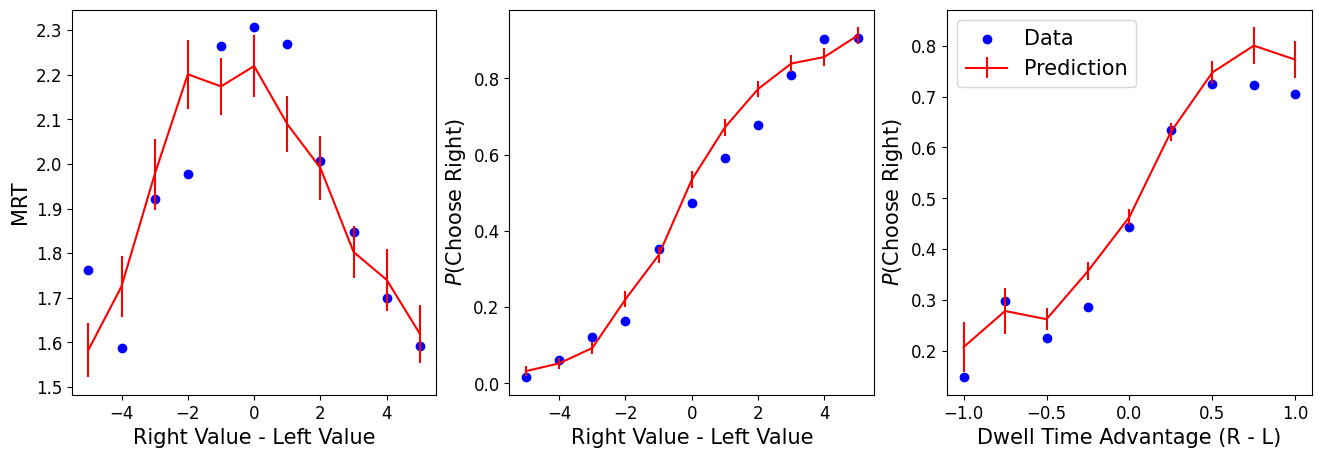

In [21]:
plt.figure(figsize=(16, 5))
plt.subplot(131)
se = pred_bhv.groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(pred_bhv.groupby(by='value_diff')['value_diff'].mean(),
             pred_bhv.groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red')
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(132)
se = pred_bhv.groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv.groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df.groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df.groupby(by='Right Value - Left Value')['choice'].mean()-1, c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(133)
se = pred_bhv.groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv.shape[0])
plt.errorbar(x=pred_bhv.groupby(by='gaze_diff')['gaze_diff'].mean(),
             y=pred_bhv.groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df.groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df.groupby(by='Dwell Time Advantage (R - L)')['choice'].mean()-1, 
            c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/kr2010_splitted_postpred.png', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight')
plt.savefig('_plots/kr2010_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

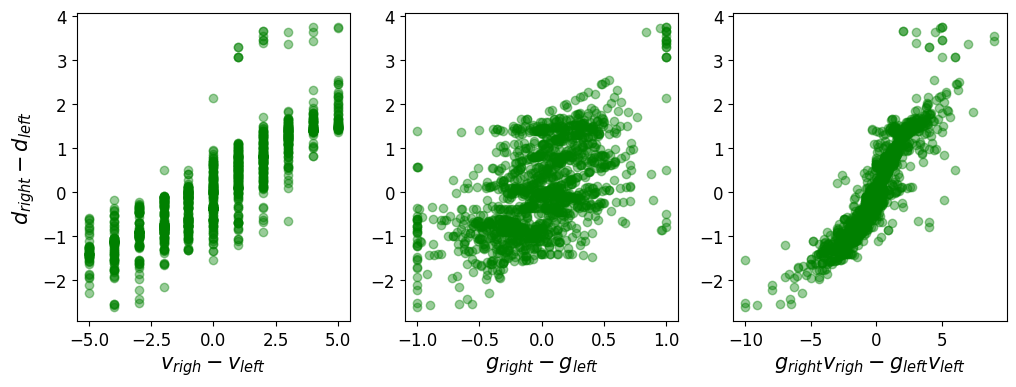

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] - X_test[:, 1], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');
plt.xlabel(r'$v_{righ} - v_{left}$ ');

plt.subplot(132)
plt.scatter(X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(133)
plt.scatter(X_test[:, 0]*X_test[:, 2] - X_test[:, 1]*X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.4, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/kr2010_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');